In [1]:
import pandas as pd
from pathlib import Path
import re

pd.set_option('display.max_columns',50)

In [2]:
#Import CSV's

austin_ride_pd = pd.read_csv('https://raw.githubusercontent.com/jchay3/james_hay_project_2_Compare_ride_patterns_and_predictive_modeling_of_rides_by-_transport_x/main/Austin%20Ride%20data%20without%20customer%20info.csv')


In [ ]:
#Display Data
austin_ride_pd.head()


,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles
0,555803,Vincent Iyamu,Ride Now,A,Vincent Iyamu,West Campus,NaN,Downtown,Charles Alan Wright Fields at the Berry M. Whi...,NaN,03/04/2025 08:22 PM (CST),03/04/2025 08:35 PM (CST),8186011505,Completed,NaN,NaN,0.0,0,0,0,0,52.47,2.44
1,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,57.10,2.13
2,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39
3,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16
4,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60


In [4]:
#Import Weather data
!pip install openmeteo-requests

!pip install requests-cache retry-requests numpy pandas

In [5]:
#Import Weahther call


import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [6]:
#set up API Client
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [7]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
locations = [
	(30.2672, -97.7431), # Austin, Tx
    (30.4433, -91.1875), # Baton Rouge, LA
    (33.749, -84.388) # Atlanta, GA
]

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 30.2672,
	"longitude": -97.7431,
	"start_date": "2023-12-31",
	"end_date": "2025-03-01",
	"hourly": ["temperature_2m", "precipitation", "rain", "snowfall", "cloud_cover", "wind_speed_10m"],
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

In [8]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 30.26361846923828°N -97.69320678710938°E
Elevation 157.0 m asl
Timezone b'America/Chicago' b'GMT-5'
Timezone difference to GMT+0 -18000 s


In [10]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m


hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

                           date  temperature_2m  precipitation  rain  \
0     2023-12-31 05:00:00+00:00       10.658501            0.0   0.0   
1     2023-12-31 06:00:00+00:00       10.258500            0.0   0.0   
2     2023-12-31 07:00:00+00:00        9.908501            0.0   0.0   
3     2023-12-31 08:00:00+00:00        9.308500            0.0   0.0   
4     2023-12-31 09:00:00+00:00        8.508500            0.0   0.0   
...                         ...             ...            ...   ...   
10243 2025-03-02 00:00:00+00:00       24.258501            0.0   0.0   
10244 2025-03-02 01:00:00+00:00       23.708500            0.0   0.0   
10245 2025-03-02 02:00:00+00:00       22.858500            0.0   0.0   
10246 2025-03-02 03:00:00+00:00       21.308500            0.0   0.0   
10247 2025-03-02 04:00:00+00:00       19.808500            0.0   0.0   

       snowfall  cloud_cover  wind_speed_10m  
0           0.0         99.0       11.525623  
1           0.0         98.0       11.525

In [11]:
hourly_dataframe.head(5)

,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m
0,2023-12-31 05:00:00+00:00,10.658501,0.0,0.0,0.0,99.0,11.525623
1,2023-12-31 06:00:00+00:00,10.258500,0.0,0.0,0.0,98.0,11.525623
2,2023-12-31 07:00:00+00:00,9.908501,0.0,0.0,0.0,100.0,11.753876
3,2023-12-31 08:00:00+00:00,9.308500,0.0,0.0,0.0,100.0,10.383987
4,2023-12-31 09:00:00+00:00,8.508500,0.0,0.0,0.0,99.0,9.693296


In [12]:
#Confirm we have data up until march 1 2025
hourly_dataframe.tail(20)

,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m
10228,2025-03-01 09:00:00+00:00,12.258500,0.0,0.0,0.0,0.0,5.483356
10229,2025-03-01 10:00:00+00:00,11.908501,0.0,0.0,0.0,0.0,6.034700
10230,2025-03-01 11:00:00+00:00,11.208500,0.0,0.0,0.0,7.0,5.411986
10231,2025-03-01 12:00:00+00:00,11.008500,0.0,0.0,0.0,1.0,6.287130
10232,2025-03-01 13:00:00+00:00,9.758500,0.0,0.0,0.0,0.0,7.380000
10233,2025-03-01 14:00:00+00:00,11.358500,0.0,0.0,0.0,33.0,8.258451
10234,2025-03-01 15:00:00+00:00,14.858500,0.0,0.0,0.0,43.0,4.829907
10235,2025-03-01 16:00:00+00:00,18.908501,0.0,0.0,0.0,4.0,3.947708
10236,2025-03-01 17:00:00+00:00,22.458500,0.0,0.0,0.0,0.0,3.189608
10237,2025-03-01 18:00:00+00:00,24.908501,0.0,0.0,0.0,13.0,2.675892


In [13]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            10248 non-null  datetime64[ns, UTC]
 1   temperature_2m  10248 non-null  float32            
 2   precipitation   10248 non-null  float32            
 3   rain            10248 non-null  float32            
 4   snowfall        10248 non-null  float32            
 5   cloud_cover     10248 non-null  float32            
 6   wind_speed_10m  10248 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(6)
memory usage: 320.4 KB


In [14]:
#Explore value types

austin_ride_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7449 entries, 0 to 7448
Data columns (total 23 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   ride_id                                                     7449 non-null   int64  
 1   vehicle_number                                              7449 non-null   object 
 2   ride_type                                                   7449 non-null   object 
 3   proximity                                                   7335 non-null   object 
 4   driver_name                                                 7449 non-null   object 
 5   pickup                                                      7449 non-null   object 
 6   radius_schedule_pickup_dispatch_text                        1379 non-null   object 
 7   pickup_driver_zone                                          4538 non-null   object 
 8 

In [15]:
#Use Regex to remove CST from the orginal Ride Start time
austin_ride_pd['ride_start_date_time_cleaned'] = austin_ride_pd['ride_start_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)
austin_ride_pd['ride_end_date_time_cleaned'] = austin_ride_pd['ride_end_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)

austin_ride_pd['ride_start_date_time_converted'] = pd.to_datetime(austin_ride_pd['ride_start_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')
austin_ride_pd['ride_end_date_time_converted'] = pd.to_datetime(austin_ride_pd['ride_end_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')

austin_ride_pd

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted
0,555803,Vincent Iyamu,Ride Now,A,Vincent Iyamu,West Campus,NaN,Downtown,Charles Alan Wright Fields at the Berry M. Whi...,NaN,03/04/2025 08:22 PM (CST),03/04/2025 08:35 PM (CST),8186011505,Completed,NaN,NaN,0.0,0,0,0,0,52.47,2.44,03/04/2025 08:22 PM,03/04/2025 08:35 PM,2025-03-04 20:22:00,2025-03-04 20:35:00
1,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,57.10,2.13,03/04/2025 07:23 PM,03/04/2025 07:35 PM,2025-03-04 19:23:00,2025-03-04 19:35:00
2,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00
3,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00
4,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00
7445,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00
7446,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00
7447,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00


In [16]:
#Convert weathher time to match converted time of Ride info 

hourly_dataframe['date_converted'] = (
    pd.to_datetime(hourly_dataframe['date'], format='%m/%d/%Y %I:%M %p')
    .dt.tz_localize(None)
)
hourly_dataframe


,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,2023-12-31 05:00:00+00:00,10.658501,0.0,0.0,0.0,99.0,11.525623,2023-12-31 05:00:00
1,2023-12-31 06:00:00+00:00,10.258500,0.0,0.0,0.0,98.0,11.525623,2023-12-31 06:00:00
2,2023-12-31 07:00:00+00:00,9.908501,0.0,0.0,0.0,100.0,11.753876,2023-12-31 07:00:00
3,2023-12-31 08:00:00+00:00,9.308500,0.0,0.0,0.0,100.0,10.383987,2023-12-31 08:00:00
4,2023-12-31 09:00:00+00:00,8.508500,0.0,0.0,0.0,99.0,9.693296,2023-12-31 09:00:00
...,...,...,...,...,...,...,...,...
10243,2025-03-02 00:00:00+00:00,24.258501,0.0,0.0,0.0,51.0,8.827344,2025-03-02 00:00:00
10244,2025-03-02 01:00:00+00:00,23.708500,0.0,0.0,0.0,100.0,9.807935,2025-03-02 01:00:00
10245,2025-03-02 02:00:00+00:00,22.858500,0.0,0.0,0.0,100.0,10.692969,2025-03-02 02:00:00
10246,2025-03-02 03:00:00+00:00,21.308500,0.0,0.0,0.0,100.0,8.197414,2025-03-02 03:00:00


In [17]:
# Merge on the ride start time with weather data for that time
austin_merged_data = pd.merge_asof(
    austin_ride_pd.sort_values('ride_start_date_time_converted'), 
    hourly_dataframe.sort_values('date_converted'), 
    left_on='ride_start_date_time_converted', 
    right_on='date_converted', 
    direction='backward'  
)

austin_merged_data

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,252846,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,South Austin,NaN,NaN,3850 Burnham,NaN,01/01/2024 12:48 AM (CST),01/01/2024 01:00 AM (CST),2542293800,Completed,NaN,NaN,0.0,0,0,1,0,93.84,11.96,01/01/2024 12:48 AM,01/01/2024 01:00 AM,2024-01-01 00:48:00,2024-01-01 01:00:00,2024-01-01 00:00:00+00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,2024-01-01 00:00:00
1,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
2,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
3,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
4,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7445,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7446,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7447,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,Na

In [18]:
#Create a funnction that produces a ride time column by figuring out difference between start and end times of rides

def calculate_ride_duration(start_time, end_time):
    return (end_time - start_time).total_seconds() / 60

austin_merged_data['total_ride_time_minutes'] = austin_merged_data.apply(
    lambda row: calculate_ride_duration(row['ride_start_date_time_converted'], row['ride_end_date_time_converted']), axis=1
)

print(austin_merged_data[['ride_start_date_time_converted', 'ride_end_date_time_converted', 'total_ride_time_minutes']].head())


  ride_start_date_time_converted ride_end_date_time_converted  \
0            2024-01-01 00:48:00          2024-01-01 01:00:00   
1            2024-01-01 01:00:00          2024-01-01 01:29:00   
2            2024-01-01 01:21:00          2024-01-01 01:34:00   
3            2024-01-01 01:50:00          2024-01-01 02:00:00   
4            2024-01-01 01:55:00          2024-01-01 02:00:00   

   total_ride_time_minutes  
0                     12.0  
1                     29.0  
2                     13.0  
3                     10.0  
4                      5.0  


In [19]:
austin_merged_data

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted,total_ride_time_minutes
0,252846,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,South Austin,NaN,NaN,3850 Burnham,NaN,01/01/2024 12:48 AM (CST),01/01/2024 01:00 AM (CST),2542293800,Completed,NaN,NaN,0.0,0,0,1,0,93.84,11.96,01/01/2024 12:48 AM,01/01/2024 01:00 AM,2024-01-01 00:48:00,2024-01-01 01:00:00,2024-01-01 00:00:00+00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,2024-01-01 00:00:00,12.0
1,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,29.0
2,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,13.0
3,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,10.0
4,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,9.0
7445,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,21.0
7446,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,7.0
7447,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:

In [20]:
#drop unwanted columns and create a cleaned DF

columns_to_drop = [
    'ride_id', 'vehicle_number', 'ride_type', 'proximity', 'driver_name', 'pickup', 
    'radius_schedule_pickup_dispatch_text', 'pickup_driver_zone', 'departure', 
    'dropoff_driver_zone', 'ride_start_date_time', 'ride_end_date_time', 'customer_mobile', 
    'ride_status', 'allow_start_ride_at', 'allow_start_ride_description', 
    'long_distance_pickup_fee', 'long_distance_pickup_min_passengers', 
    'checkedin_passengers_after_finish_boarding_confirmed_count', 
    'is_rescan_data_available', 'ride_end_date_time_cleaned', 
    'ride_start_date_time_cleaned', 'date_converted', 'date', 
]

austin_cleaned = austin_merged_data.drop(columns=columns_to_drop)

austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
#Create a scatter plot to visualize ride times vs Revenue

lt.figure(figsize=(8, 6))
sns.scatterplot(data=austin_cleaned, x='total_ride_time_minutes', y='total_revenue', alpha=0.7)
plt.xlabel('Total Ride Time (Minutes)')
plt.ylabel('Total Revenue ($)')
plt.title('Total Ride Time vs. Revenue')
plt.grid(True)
plt.show()

NameError: name 'lt' is not defined

C:\Users\jchay\AppData\Local\Temp\ipykernel_58812\4263301152.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = austin_cleaned.pivot_table(


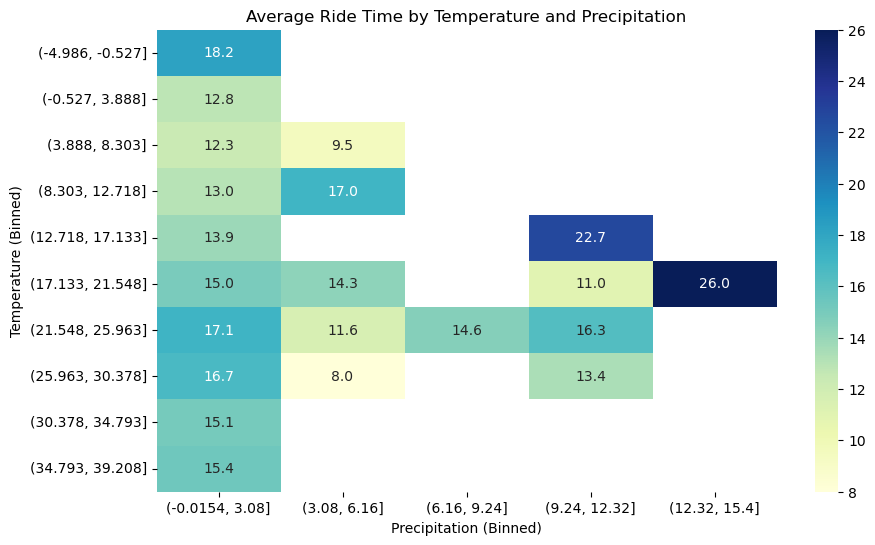

In [29]:
#create Heat map showing Average Ride time with percipatation and Temp

pivot_data = austin_cleaned.pivot_table(
    index=pd.cut(austin_cleaned['temperature_2m'], bins=10),
    columns=pd.cut(austin_cleaned['precipitation'], bins=5),
    values='total_ride_time_minutes',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f')
plt.xlabel('Precipitation (Binned)')
plt.ylabel('Temperature (Binned)')
plt.title('Average Ride Time by Temperature and Precipitation')
plt.show()

In [30]:
#Create usable precipitation categories

austin_cleaned['total_precipitation'] = austin_cleaned['rain'] + austin_cleaned['snowfall']

bins = [0, 0.5, 2, 5, np.inf]  
labels = ['None', 'Light', 'Medium', 'Heavy']

austin_cleaned['precipitation_category'] = pd.cut(austin_cleaned['total_precipitation'], bins=bins, labels=labels, right=False)
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None


In [31]:
#Apply a log transformation which can better help visualize this data since its often close to 0

austin_cleaned['log_total_precipitation'] = np.log1p(austin_cleaned['total_precipitation'])


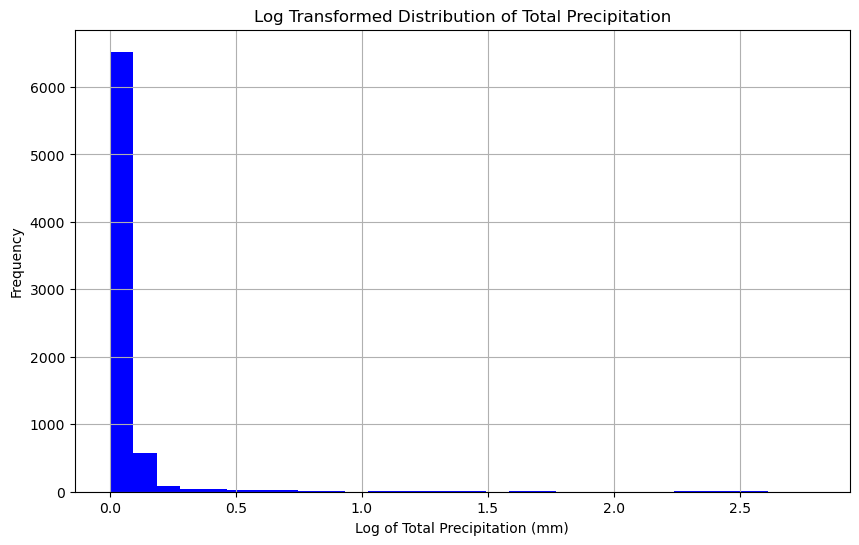

In [32]:
#Create the Graph 

plt.figure(figsize=(10, 6))
plt.hist(austin_cleaned['log_total_precipitation'], bins=30, color='blue')
plt.title('Log Transformed Distribution of Total Precipitation')
plt.xlabel('Log of Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [33]:
print(austin_cleaned['log_total_precipitation'].describe())

count    7449.000000
mean        0.047537
std         0.224291
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.797281
Name: log_total_precipitation, dtype: float64


In [34]:
austin_cleaned['precipitation_category'].value_counts()

precipitation_category
None      7216
Light      140
Medium      63
Heavy       30
Name: count, dtype: int64

In [43]:
#Create a mean revenue for each Precipitation category

revenue_by_precipitation = austin_cleaned.groupby('precipitation_category')['total_revenue'].mean()
revenue_by_precipitation

C:\Users\jchay\AppData\Local\Temp\ipykernel_26836\4227037375.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_precipitation = austin_cleaned.groupby('precipitation_category')['total_revenue'].mean()


precipitation_category
None      82.655962
Light     75.171786
Medium    69.748095
Heavy     83.090000
Name: total_revenue, dtype: float64

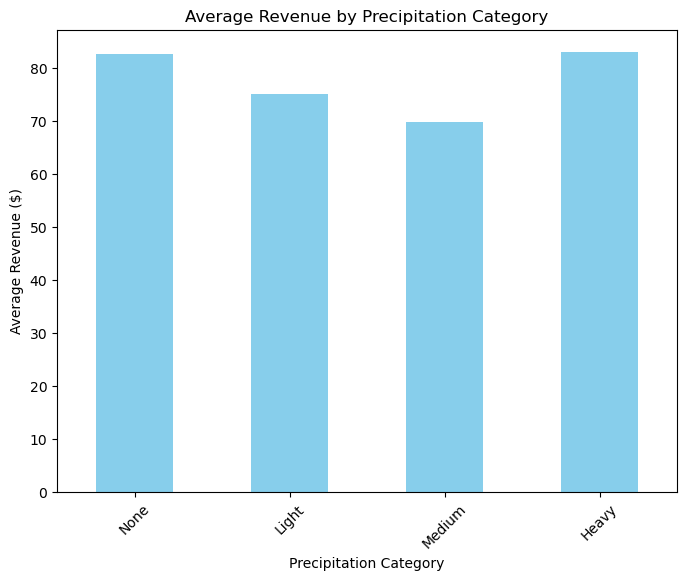

In [ ]:
#Visualize the Revenue by precipation data

plt.figure(figsize=(8, 6))
revenue_by_precipitation.plot(kind='bar', color='skyblue')
plt.xlabel('Precipitation')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Precipitation Category')
plt.xticks(rotation=45)
plt.show()

In [48]:
#Correlate the data by precipitation category utilizing Total revenue, Ride time, and Ride Miles)
austin_correlation_by_precipitation_type = austin_cleaned.groupby('precipitation_category')[['total_revenue', 'total_ride_time_minutes', 'ride_miles']].corr()
print(austin_correlation_by_precipitation_type)

                                                total_revenue  \
precipitation_category                                          
None                   total_revenue                 1.000000   
                       total_ride_time_minutes       0.730790   
                       ride_miles                    0.844857   
Light                  total_revenue                 1.000000   
                       total_ride_time_minutes       0.630205   
                       ride_miles                    0.824573   
Medium                 total_revenue                 1.000000   
                       total_ride_time_minutes       0.421122   
                       ride_miles                    0.406531   
Heavy                  total_revenue                 1.000000   
                       total_ride_time_minutes       0.651219   
                       ride_miles                    0.818279   

                                                total_ride_time_minutes  \
precipitation_

C:\Users\jchay\AppData\Local\Temp\ipykernel_26836\837665552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  austin_correlation_by_precipitation_type = austin_cleaned.groupby('precipitation_category')[['total_revenue', 'total_ride_time_minutes', 'ride_miles']].corr()


In [49]:
   # Calculate Revenue per mile
austin_cleaned['revenue_per_mile'] = austin_cleaned['total_revenue'] / austin_cleaned['ride_miles']   
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,log_total_precipitation,precipitation_category,revenue_per_mile
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0.0,None,7.846154
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0.0,None,25.689655
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0.0,None,15.014041
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0.0,None,16.800000
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0.0,None,55.312057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,18.858500,0.0,0.0,0.0,98.0,7.536392,9.0,0.0,0.0,None,31.769231
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,18.858500,0.0,0.0,0.0,98.0,7.536392,21.0,0.0,0.0,None,29.129630
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,18.858500,0.0,0.0,0.0,98.0,7.536392,7.0,0.0,0.0,None,23.223022
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,18.858500,0.0,0.0,0.0,98.0,7.536392,12.0,0.0,0.0,None,26.807512


In [ ]:
#Group by percipiation category and calulate the mean revenue per mile

austin_revenue_per_mile = austin_cleaned.groupby('precipitation_category')['revenue_per_mile'].mean().reset_index()

C:\Users\jchay\AppData\Local\Temp\ipykernel_26836\1188194503.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  austin_revenue_per_mile = austin_cleaned.groupby('precipitation_category')['revenue_per_mile'].mean().reset_index()


C:\Users\jchay\AppData\Local\Temp\ipykernel_26836\663800420.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='precipitation_category', y='revenue_per_mile', data=austin_revenue_per_mile, palette='viridis')


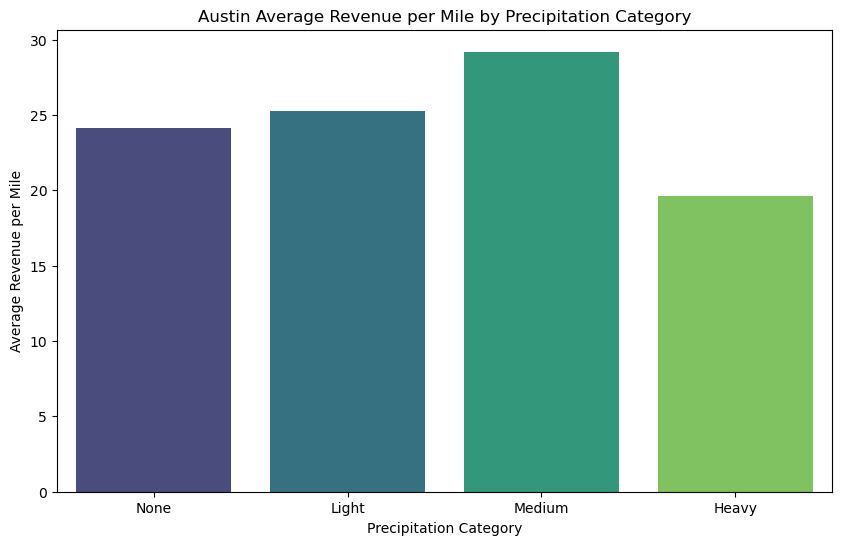

In [55]:
#Create Bar Chart Showing different percipitation categories
plt.figure(figsize=(10, 6))
sns.barplot(x='precipitation_category', y='revenue_per_mile', data=austin_revenue_per_mile, palette='viridis')
plt.xlabel('Precipitation Category')
plt.ylabel('Average Revenue per Mile')
plt.title('Austin Average Revenue per Mile by Precipitation Category')

plt.show()

In [37]:
#Create Revenue by minute

austin_cleaned['revenue_per_minute'] = austin_cleaned['total_revenue'] / austin_cleaned['total_ride_time_minutes']
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_minute
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None,0.0,7.820000
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None,0.0,1.798276
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None,0.0,7.403077
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None,0.0,5.628000
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None,0.0,15.598000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None,0.0,9.177778
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None,0.0,2.996190
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None,0.0,4.611429
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None,0.0,4.758333


C:\Users\jchay\AppData\Local\Temp\ipykernel_58812\1762332546.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='precipitation_category', y='revenue_per_minute', data=austin_cleaned, palette='Blues')


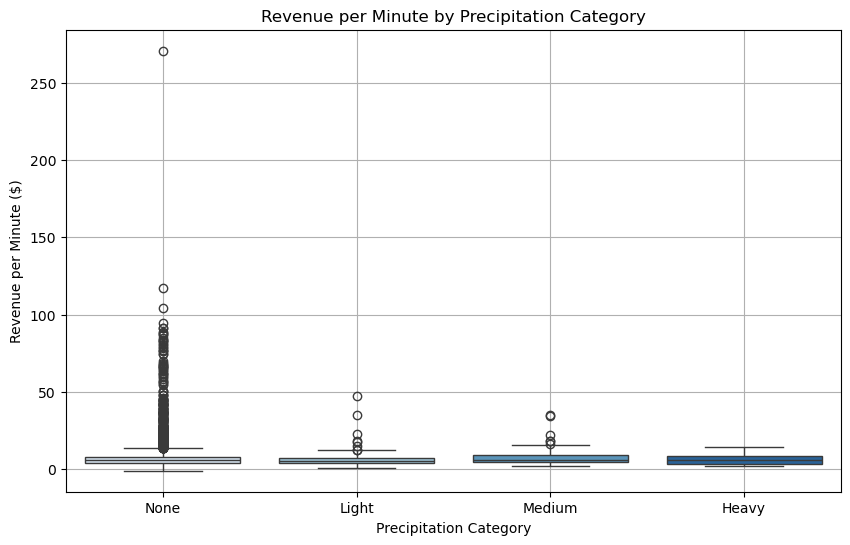

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='precipitation_category', y='revenue_per_minute', data=austin_cleaned, palette='Blues')
plt.xlabel('Precipitation Category')
plt.ylabel('Revenue per Minute ($)')
plt.title('Revenue per Minute by Precipitation Category')
plt.grid(True)

plt.show()

C:\Users\jchay\AppData\Local\Temp\ipykernel_58812\1386585965.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = austin_cleaned.pivot_table(index='hour', columns='precipitation_category', values='revenue_per_minute', aggfunc='mean')


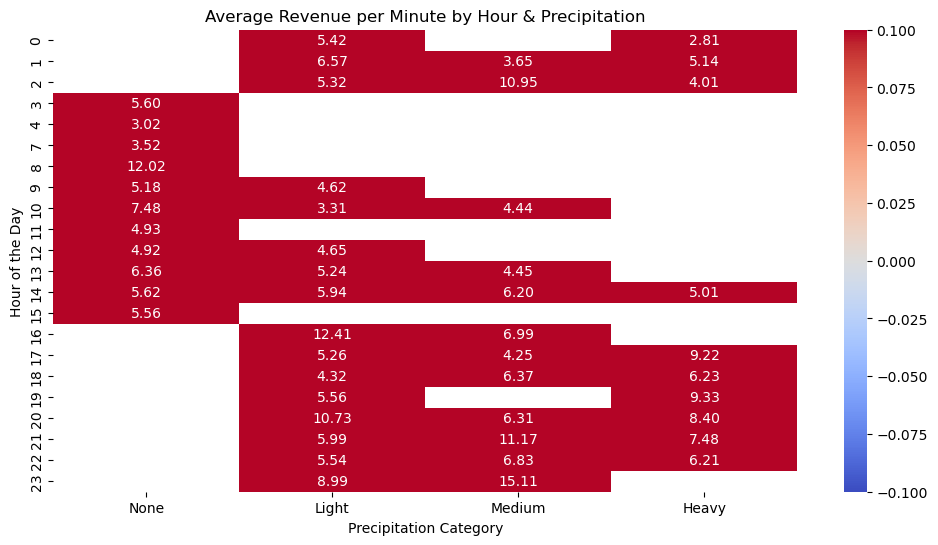

In [41]:
austin_cleaned['hour'] = austin_cleaned['ride_start_date_time_converted'].dt.hour

# Pivot table for heatmap
heatmap_data = austin_cleaned.pivot_table(index='hour', columns='precipitation_category', values='revenue_per_minute', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")

plt.xlabel('Precipitation Category')
plt.ylabel('Hour of the Day')
plt.title('Average Revenue per Minute by Hour & Precipitation')
plt.show()

In [ ]:
#Add Revenue per mile
austin_cleaned['revenue_per_mile'] = austin_cleaned['total_revenue'] / austin_cleaned['ride_miles']   
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_minute,hour,revenue_per_mile
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None,0.0,7.820000,0,7.846154
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None,0.0,1.798276,1,25.689655
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None,0.0,7.403077,1,15.014041
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None,0.0,5.628000,1,16.800000
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None,0.0,15.598000,1,55.312057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None,0.0,9.177778,21,31.769231
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None,0.0,2.996190,17,29.129630
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None,0.0,4.611429,17,23.223022
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None,0.0,4.758333,19,26.807512


In [57]:
print(austin_cleaned.isnull().sum())

age_surge_charge                  0
total_revenue                     0
ride_miles                        0
ride_start_date_time_converted    0
ride_end_date_time_converted      0
temperature_2m                    0
precipitation                     0
rain                              0
snowfall                          0
cloud_cover                       0
wind_speed_10m                    0
total_ride_time_minutes           0
total_precipitation               0
precipitation_category            0
log_total_precipitation           0
revenue_per_minute                0
hour                              0
revenue_per_mile                  0
revenue_category                  0
dtype: int64


In [58]:
print(austin_cleaned.dtypes)

age_surge_charge                           int64
total_revenue                            float64
ride_miles                               float64
ride_start_date_time_converted    datetime64[ns]
ride_end_date_time_converted      datetime64[ns]
temperature_2m                           float32
precipitation                            float32
rain                                     float32
snowfall                                 float32
cloud_cover                              float32
wind_speed_10m                           float32
total_ride_time_minutes                  float64
total_precipitation                      float32
precipitation_category                  category
log_total_precipitation                  float32
revenue_per_minute                       float64
hour                                       int32
revenue_per_mile                         float64
revenue_category                        category
dtype: object


In [59]:
# Convert categorical columns to numeric codes
austin_cleaned['precipitation_category'] = austin_cleaned['precipitation_category'].cat.codes

# Check for missing values
print(austin_cleaned.isnull().sum())

# Drop or fill missing values
austin_cleaned = austin_cleaned.dropna()

age_surge_charge                  0
total_revenue                     0
ride_miles                        0
ride_start_date_time_converted    0
ride_end_date_time_converted      0
temperature_2m                    0
precipitation                     0
rain                              0
snowfall                          0
cloud_cover                       0
wind_speed_10m                    0
total_ride_time_minutes           0
total_precipitation               0
precipitation_category            0
log_total_precipitation           0
revenue_per_minute                0
hour                              0
revenue_per_mile                  0
revenue_category                  0
dtype: int64


In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Change precipitation category to numerical values
austin_cleaned['precipitation_category'] = austin_cleaned['precipitation_category'].astype('category').cat.codes
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_minute,hour,revenue_per_mile,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.820000,0,7.846154,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,1.798276,1,25.689655,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,7.403077,1,15.014041,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,5.628000,1,16.800000,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,15.598000,1,55.312057,1


In [65]:

# Convert total_revenue into categories
austin_cleaned['revenue_category'] = pd.qcut(austin_cleaned['total_revenue'], q=3, labels=[0, 1, 2])
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_minute,hour,revenue_per_mile,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.820000,0,7.846154,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,1.798276,1,25.689655,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,7.403077,1,15.014041,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,5.628000,1,16.800000,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,15.598000,1,55.312057,1


In [66]:

# Drop rows with NaN values after binning
austin_cleaned = austin_cleaned.dropna(subset=['revenue_category'])
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_minute,hour,revenue_per_mile,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.820000,0,7.846154,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,1.798276,1,25.689655,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,7.403077,1,15.014041,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,5.628000,1,16.800000,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,15.598000,1,55.312057,1


In [ ]:

# Define features (X) and target (y)
X = austin_cleaned[['revenue_per_mile', 'revenue_per_minute', 'precipitation_category']]
y = austin_cleaned['revenue_category']
total time and total miles
miles per minute. 

how can i make this model 
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.head()

C:\Users\jchay\AppData\Local\Temp\ipykernel_58812\383592710.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


,revenue_per_mile,revenue_per_minute,precipitation_category
0,7.846154,7.820000,0
1,25.689655,1.798276,0
2,15.014041,7.403077,0
3,16.800000,5.628000,0
4,55.312057,15.598000,0


In [68]:

# Check if NaNs exist and remove them
X = X.dropna()
y = y.loc[X.index]  

# Clip extreme values
X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66       511
           1       0.54      0.53      0.54       463
           2       0.65      0.65      0.65       509

    accuracy                           0.62      1483
   macro avg       0.62      0.62      0.62      1483
weighted avg       0.62      0.62      0.62      1483



In [ ]:

#Create buckets for temp and or time series regression/ or if is raining 
#Likely too be random forest 
# Go to API and get future weater data and do revenue prediction
#How many rides based of revenue
#Total revenue expectation 
#Simple assumptions for Atlanta
#Then take Atlanta rides and understand how much money you would make in that market
#How many rides per day. measure against Uber in both cities
#Surcharge for peak times

